# ViT Scratch Implementation

![](https://miro.medium.com/v2/resize:fit:720/0*YRDqyaLnCJscrYWV)

In [1]:
# get the image
# !wget -O cat.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw&usqp=CAU


In [2]:
# install extra library
! pip install --quiet einops torchsummary


In [3]:
# Necessary Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn

from PIL import Image
import torchvision.transforms as T
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [4]:
# load image
img = Image.open("/kaggle/input/cat-and-dog-classifier/data/Cat/1200px-Cat03.jpg")


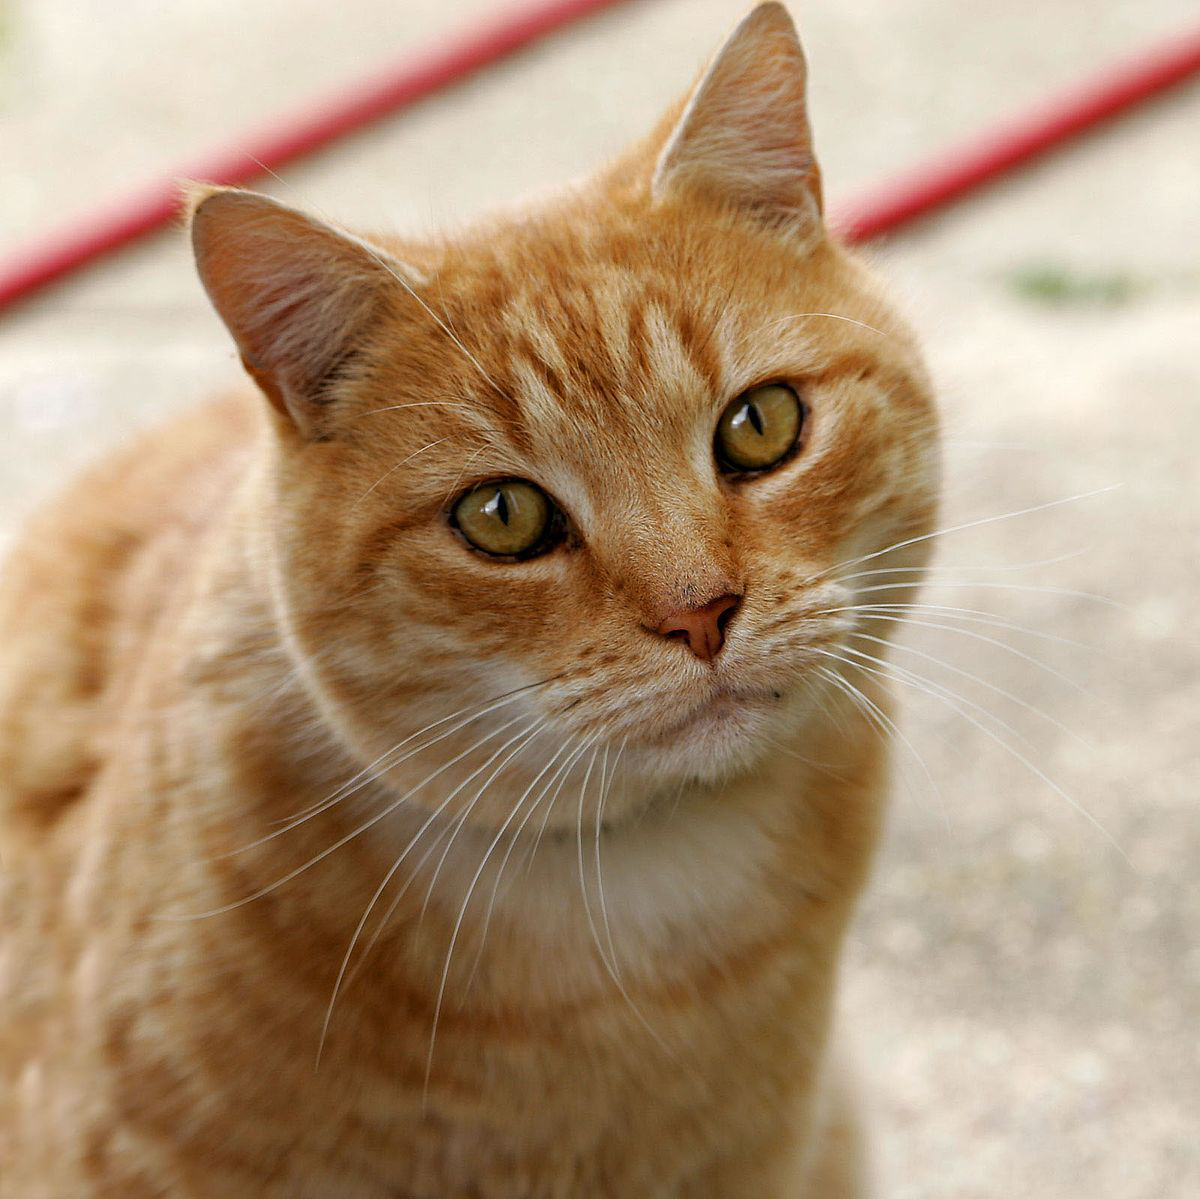

In [5]:
img

In [6]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [7]:
# add batch dimension
x = transforms(img)
x = x[None, ...]
x.shape

torch.Size([1, 3, 224, 224])

## Patch Embedding

**The first step is to break-down the image in multiple patches and flatten them.**

Quoting from the paper:
![](https://miro.medium.com/v2/resize:fit:1400/0*GF4a5rlXylMbyZKE)

In [8]:
patch_size = 16
patches = rearrange(
    x,
    'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',
    s1=patch_size,
    s2=patch_size
)

In [9]:
patches.shape

torch.Size([1, 196, 768])

In [10]:
patches_d = rearrange(
    x,
    'b c (h s1) (w s2) -> b h w s1 s2 c',
    s1 = 16,
    s2 = 16
)
patches_d.shape

torch.Size([1, 14, 14, 16, 16, 3])

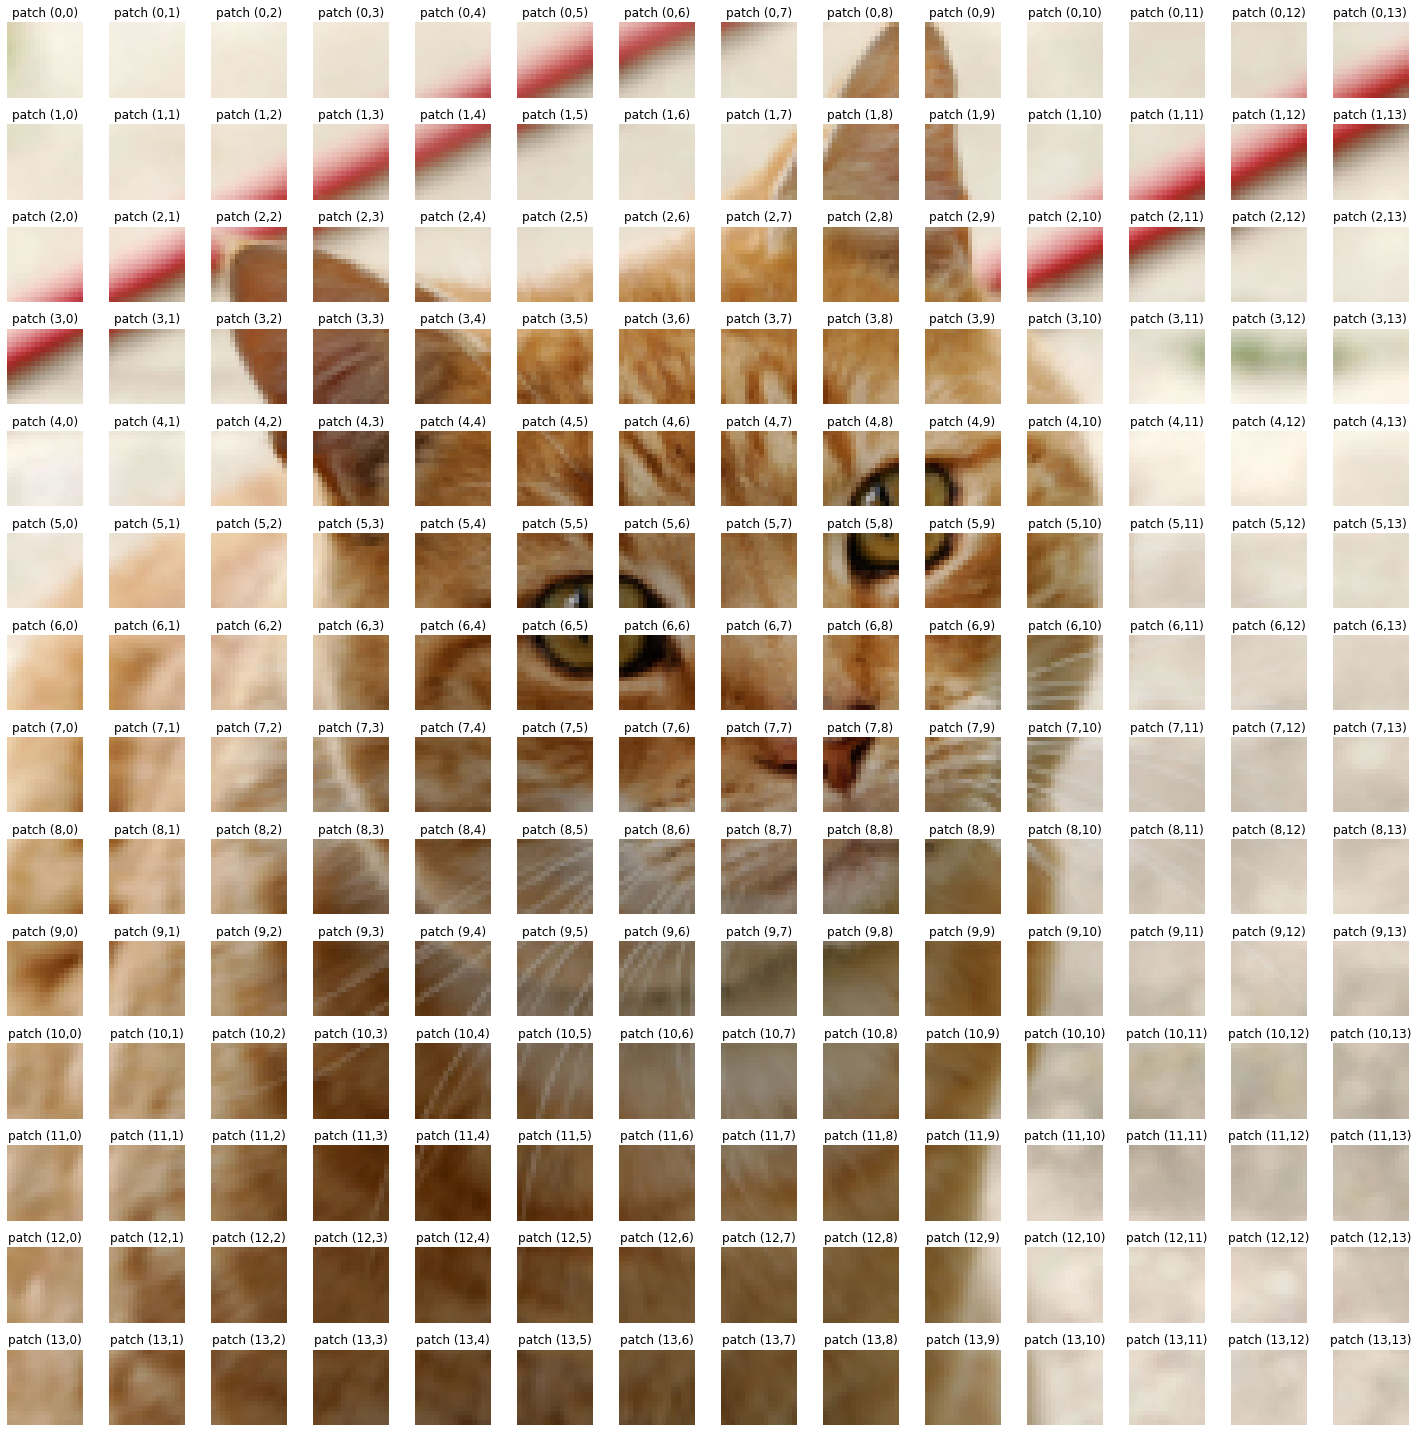

In [11]:
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(20, 20))
for i, j in itertools.product(range(14), repeat=2):
    axes[i, j].imshow(patches_d[0, i, j])
    axes[i, j].axis('off')
    axes[i, j].set_title(f"patch ({i},{j})")
fig.tight_layout()
plt.show()

**Now, we need to project them using a normal linear layer**:

![](https://miro.medium.com/v2/resize:fit:720/0*kEANaRaJkCPu685t)

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, in_channels = 3, patch_size = 16, emb_size = 768
    ):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x):
        x = self.projection(x)

        return x
     

In [13]:
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

`CLS` Token

think of this like, one patch is dedicated to `CLS` token, `16*16*3` in shape

In [14]:
torch.randn(1, 1, 768).shape

torch.Size([1, 1, 768])

Positions
Each of the path is going to have a position, also the cls token patch.

In [15]:
torch.randn((224 // 16) * (224 // 16) + 1, 786).shape

torch.Size([197, 786])

### CLS Token and Position Embedding

Next step is to add the cls token and the position embedding. The cls token is just a number placed in from of each sequence (of projected patches)

#### Position Embedding:
So far, the model has no idea about the original position of the patches. We need to pass this spatial information. This can be done in different ways, in ViT we let the model learn it. The position embedding is just a tensor of shape `N_PATCHES + 1 (token), EMBED_SIZE` that is added to the projected patches.

![](https://miro.medium.com/v2/resize:fit:720/0*F_igiisSnY9tUeAK)

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, in_channels = 3, patch_size = 16, emb_size = 768, img_size = 224,
    ):
        super(PatchEmbedding, self).__init__()

        assert img_size / patch_size % 1 == 0, "img_size must be integer multiple of patch_size"

        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

        self.cls_token = nn.Parameter(
            torch.randn(1, 1, emb_size)
        )

        self.positional_emb = nn.Parameter(
            torch.randn(
                (img_size // patch_size) ** 2 + 1, # 14 x 14 patches + CLS patch
                emb_size
            )
        )

    def forward(self, x):
        B, *_ = x.shape 
        x = self.projection(x)
        # print(x.shape, )
        cls_token = repeat(self.cls_token, '() p e -> b p e', b = B)

        # print(cls_token.shape)

        x = torch.cat([cls_token, x], dim=1)

        x += self.positional_emb

        return x

In [17]:
patch_embedding = PatchEmbedding()(x)
patch_embedding.shape

torch.Size([1, 197, 768])

`cls_token` is a torch Parameter randomly initialized, in the forward the method it is copied b (batch) times and prepended before the projected patches using `torch.cat`.

Also, We added the position embedding in the .positions field and sum it to the patches in the .forward function

## Transformer Encoder
Now we need the implement Transformer. In ViT only the Encoder is used, the architecture is visualized in the following picture.


![](https://miro.medium.com/v2/resize:fit:640/0*CEAbGqaYWUf-70n0)

## Multi-head Attention
So, the attention takes three inputs, the famous queries, keys, and values, and computes the attention matrix using queries and values and use it to “attend” to the values. In this case, we are using multi-head attention meaning that the computation is split across n heads with smaller input size.

![](https://miro.medium.com/v2/resize:fit:556/0*M6_3k8QxWz-KwILg)



In [18]:
keys = nn.Linear(768, 768)
queries = nn.Linear(768, 768)
values = nn.Linear(768, 768)

projection = nn.Linear(768, 768)

In [19]:
energy = torch.matmul(queries(patch_embedding), keys(patch_embedding).permute(0, 2, 1))
energy.shape

torch.Size([1, 197, 197])

In [20]:
attention = F.softmax(energy, dim=-1)
attention.shape

torch.Size([1, 197, 197])

In [21]:
torch.sum(attention[0, 0, :])

tensor(1.0000, grad_fn=<SumBackward0>)

In [22]:
attention.shape, values(patch_embedding).shape

(torch.Size([1, 197, 197]), torch.Size([1, 197, 768]))

In [23]:
out = torch.matmul(attention, values(patch_embedding))
out.shape

torch.Size([1, 197, 768])

In [24]:
projection(out).shape


torch.Size([1, 197, 768])

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self, 
        emb_size = 768,
        num_heads = 8,
        dropout = 0
    ):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.emb_size = emb_size
        
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        
        self.projection = nn.Linear(emb_size, emb_size)
        
        self.attn_dropout = nn.Dropout(dropout)
        
        self.scaling = (self.emb_size // num_heads) ** -0.5
        
    def forward(self, x, mask=None):
        rearrange_heads = 'batch seq_len (num_head h_dim) -> batch num_head seq_len h_dim'
        
        queries = rearrange(
            self.query(x),
            rearrange_heads,
            num_head = self.num_heads
        )
        
        keys = rearrange(
            self.key(x),
            rearrange_heads,
            num_head = self.num_heads
        )
        
        values = rearrange(
            self.value(x),
            rearrange_heads,
            num_head = self.num_heads
        )
        # sum up over the last axis
        energies = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        
        if mask is not None:
            fill_value = torch.finfo(energies.dtype).min
            energies.mask_fill(~mask, fill_value)
            
        attention = F.softmax(energies, dim=-1) * self.scaling
        attention = self.attn_dropout(attention)
        # sum up over the third axis
        out = torch.einsum('bhas, bhsd -> bhad', attention, values)
        
        out = rearrange(out, 'batch num_head seq_length dim -> batch seq_length (num_head dim)')
        
        out = self.projection(out)
        
        return out

So, step by step. We have 4 fully connected layers, one for queries, keys, values, and a final one dropout.

Okay, the idea (really go and read [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) ) is to use the product between the queries and the keys to knowing “how much” each element is the sequence in important with the rest. Then, we use this information to scale the values.

The forward method takes as input the queries, keys, and values from the previous layer and projects them using the three linear layers. Since we implementing multi heads attention, we have to rearrange the result in multiple heads.

This is done by using rearrange from einops.

Queries, Keys and Values are always the same, so for simplicity, I have only one input ( x).

```python
        queries = rearrange(
            self.query(x),
            rearrange_heads,
            num_head = self.num_heads
        )
        
        keys = rearrange(
            self.key(x),
            rearrange_heads,
            num_head = self.num_heads
        )
        
        values = rearrange(
            self.value(x),
            rearrange_heads,
            num_head = self.num_heads
        )
```

The resulting keys, queries, and values have a shape of `BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE.`

To compute the attention matrix we first have to perform matrix multiplication between queries and keys, a.k.a sum up over the last axis. This can be easily done using `torch.einsum`

```python
   energies = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)

```

The resulting vector has the shape `BATCH, HEADS, QUERY_LEN, KEY_LEN.` Then the attention is finally the softmax of the resulting vector divided by a scaling factor based on the size of the embedding.

Lastly, we use the attention to scale the values
```python
        out = torch.einsum('bhas, bhsd -> bhad', attention, values)
```

and we obtain a vector of size `BATCH HEADS VALUES_LEN, EMBEDDING_SIZE.` We concat the heads together and we finally return the results.

We can use a single matrix to compute in one shot `queries, keys and values`.

```python
# split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
```

In [26]:
MultiHeadAttention()(patch_embedding).shape


torch.Size([1, 197, 768])

## Residuals
The transformer block has residuals connection 
![](https://miro.medium.com/v2/resize:fit:620/0*AeM9nWwmOTmIz3d6)

In [27]:
# wrapper to perform the residual addition:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

The attention’s output is passed to a fully connected layer composed of two layers that upsample by a factor of expansion the input.

In [28]:
FeedForwardBlock = lambda emb_size = 768, expansion=4, drop_p=0.: nn.Sequential(
    nn.Linear(emb_size, expansion * emb_size),
    nn.GELU(),
    nn.Dropout(drop_p),
    nn.Linear(expansion * emb_size, emb_size)
)

## Transformer Encoder Block

![](https://miro.medium.com/v2/resize:fit:640/0*ZBZu9kE-JxSCZsAv)

In [29]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(
        self,
        emb_size = 768,
        drop_p = 0.,
        forward_expansion = 4,
        forward_drop_p = 0,
        **kwargs
    ):
        super(TransformerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    MultiHeadAttention(emb_size, **kwargs),
                    nn.Dropout(drop_p)
                )
            ),
            
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                    nn.Dropout(drop_p)
                )
            )
        )

In [30]:
# test
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

# Transformer

**The encoder is L blocks of TransformerBlock**

In [31]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth = 12, **kwargs):
        super(TransformerEncoder, self).__init__(
            *(TransformerEncoderBlock(**kwargs) for _ in range(depth))
        )

In [32]:
trans_out = TransformerEncoder()(patch_embedding)
trans_out.shape

torch.Size([1, 197, 768])

## Classification Head
![](https://miro.medium.com/v2/resize:fit:640/0*OWjU6c9qXmzrUTLq)

In [33]:
class ClassificationHead(nn.Sequential):
    def __init__(
        self,
        emb_size = 768,
        num_classes = 1000
    ):
        super(
            ClassificationHead,
            self
        ).__init__(
            Reduce(
                'batch_size seq_len emb_dim -> batch_size emb_dim',
                reduction='mean'
            ),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

In [34]:
ClassificationHead()(trans_out).shape


torch.Size([1, 1000])

We can compose `PatchEmbedding`, `TransformerEncoder` and `ClassificationHead` to create the final ViT architecture.

In [35]:
class ViT(nn.Sequential):
    def __init__(
        self, 
        in_channels = 3,
        patch_size = 16,
        emb_size = 768,
        img_size = 224,
        depth = 12,
        num_classes = 1000,
        **kwargs
    ):
        super(ViT, self).__init__(
            PatchEmbedding(
                in_channels, patch_size, emb_size, img_size,
            ),
            TransformerEncoder(
                depth, emb_size=emb_size, **kwargs
            ),
            ClassificationHead(
                emb_size, num_classes
            )
        )

In [36]:
ViT()(x).shape

torch.Size([1, 1000])

In [37]:
summary(
    ViT(),
    input_size=(3, 224, 224),
    device="cpu"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 196, 768]               0
            Linear-2             [-1, 196, 768]         590,592
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1

#### Trained with CIFAR10

In [38]:
! pip install --quiet pytorch-lightning==1.7.7 torchmetrics==0.11.0 lightning-bolts==0.6.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.11.2 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.


In [39]:
from pl_bolts.datamodules import CIFAR10DataModule
from torch.optim.lr_scheduler import OneCycleLR
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

import pytorch_lightning as pl

from torchmetrics.functional import accuracy

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.7/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [40]:
config = {
    "data_dir": ".",
    "batch_size": 256,
    "num_workers": 2,
    "num_classes": 10,
    "lr": 1e-4,
    "max_lr": 1e-3,
}

In [41]:
train_transforms = T.Compose(
    [
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=config["data_dir"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

In [42]:
ViT(
    in_channels=3,
    patch_size=4,
    emb_size=128,
    img_size=32,
    depth=12,
    num_classes=10
)
  

ViT(
  (0): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=4, s2=4)
      (1): Linear(in_features=48, out_features=128, bias=True)
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (projection): Linear(in_features=128, out_features=128, bias=True)
            (attn_dropout): Dropout(p=0, inplace=False)
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): Sequential(
   

In [43]:
# test on random tensor of 32x32x3
ViT(
    in_channels=3,
    patch_size=4,
    emb_size=128,
    img_size=32,
    depth=12,
    num_classes=10
)(torch.randn(1, 3, 32, 32))

tensor([[-0.6395,  0.6231, -0.5373, -1.0565,  0.2081, -0.3316,  0.2951, -0.2728,
          0.0986,  1.3820]], grad_fn=<AddmmBackward0>)

In [44]:
class LitViT(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = ViT(
            in_channels=3,
            patch_size=4,
            emb_size=128,
            img_size=32,
            depth=12,
            num_classes=10
        )

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=config["num_classes"])

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
        )
        steps_per_epoch = 45_000 // config["batch_size"]
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=config["max_lr"],
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [45]:
model = LitViT(
    lr=config["lr"]
)
   

In [46]:
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
)

### PyTorch Lightning Auto Learning rate finder

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Auto-find model LR is:
 0.000630957344480193 ]


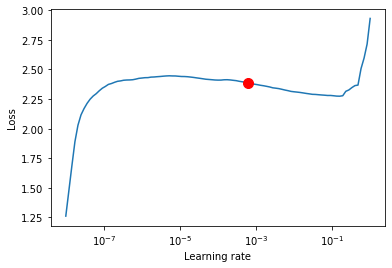

In [47]:
lr_finder = trainer.tuner.lr_find(model,cifar10_dm)

# update the current model learning rate
model.hparams.lr = lr_finder.suggestion()

print(f'Auto-find model LR is:\n {model.hparams.lr} ]')

fig = lr_finder.plot(suggest=True)

In [48]:
trainer.fit(model, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [49]:
trainer.test(model, datamodule=cifar10_dm)


Files already downloaded and verified
Files already downloaded and verified


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7580999732017517     │
│         test_loss         │    0.7092740535736084     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7092740535736084, 'test_acc': 0.7580999732017517}]

In [50]:
torch.save(model.state_dict(), "vit_model.pt")